In [1]:
%%capture capt
!pip install scikit-learn-extra
!pip install jellyfish
!pip install kneed[plot]
!pip install levenshtein

In [2]:
%%capture capt
import numpy as np
from sklearn_extra.cluster import KMedoids
from jellyfish import jaro_winkler_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from matplotlib.ticker import PercentFormatter
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from kneed import KneeLocator
import Levenshtein
from multiprocessing import Pool
import concurrent.futures

# Importation data

In [3]:
base_patient = pd.read_csv("../data/profil_patient.csv")

In [4]:
%%capture capt
p_soins = pd.read_csv("../data/parcours_soins.csv")

In [5]:
p_soins.head(3)

,BEN_NIR_IDT,2008-01-15,2008-02-15,2008-03-15,2008-04-15,2008-05-15,2008-06-15,2008-07-15,2008-08-15,2008-09-15,...,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29
0,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
base_patient.head(3)

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,Nb_jours_sej,cat_age,cat_nb_hospit,cat_nb_jours_sej,cluster
0,P0,2011-11-22,1949,11,1,NaN,False,2596,9,False,23,1,1,1,0
1,P6,2013-12-05,1929,14,2,2015-03,True,456,8,False,51,2,1,1,1
2,P8,2015-07-02,1967,54,2,2015-08,True,41,3,True,43,0,1,1,2


# Data Pre-processing

In [7]:
base_patient.Mort = base_patient.Mort.astype(int)
base_patient.CHOC = base_patient.CHOC.astype(int)
base_patient.BEN_SEX_COD = base_patient.BEN_SEX_COD-1

In [8]:
# on ne conserve que l'annee de la premiere hospitalisation

base_patient.date_h0 = pd.to_datetime(base_patient.date_h0).apply(lambda date: int(date.year))

# Lister tous les GHM

In [9]:
all_ghm = set()
for i in range(len(p_soins)):
    ghm_row = set(p_soins.iloc[i].dropna().tolist()[1:])
    all_ghm = all_ghm.union(ghm_row)   

In [10]:
nb_ghm = len(all_ghm)
print(nb_ghm)

2346


# Vecteur des parcours de GHM

In [11]:
X_patient = []
for i in range(len(base_patient)):
    ghm_row = p_soins.iloc[i].dropna().tolist()[1:]
    X_patient.append(ghm_row)

# Formules de distance entre string

##### Jaro-Winkler

In [12]:
def convert_to_sentence(arr):
    sentence = ''
    for x in arr:
        sentence += x + ","
    return sentence[:-1]

In [13]:
def string_distance(s1, s2):
    # Compute distance between strings using the jaro winkler similarity formula
    return 1 - jaro_winkler_similarity(s1, s2)

def jaro_winkler_distance(arr1, arr2):
    s1 = convert_to_sentence(arr1)
    s2 = convert_to_sentence(arr2)
    return abs(string_distance(s1, s2))

##### Levenshtein 

In [14]:
def string_distance_levenshtein(s1, s2):
    return 1 - Levenshtein.ratio(s1, s2)

def levenshtein_distance(arr1, arr2):
    s1 = convert_to_sentence(arr1)
    s2 = convert_to_sentence(arr2)
    return abs(string_distance_levenshtein(s1, s2))

##### Custom

Tous les GHM ont 6 caractères

In [15]:
def custom_ghm_distance(ghm1, ghm2, distance=string_distance_levenshtein, weights=[3,2,1]):
    if ghm1 == '' or ghm2 == '':
        return 1
    return (weights[0]*distance(ghm1[:2], ghm2[:2]) + weights[1]*distance(ghm1[2], ghm2[2]) + weights[2]*distance(ghm1[2:], ghm2[2:])) / np.sum(weights)

def fill_arr(arr, desired_length):
    new_arr = arr.copy()
    while len(new_arr) < desired_length:
        new_arr.append('')
    return new_arr

def custom_distance(arr1, arr2, distance_ghm=string_distance_levenshtein):
    length = max(len(arr1), len(arr2))
    arr1 = fill_arr(arr1, length)
    arr2 = fill_arr(arr2, length)
    distance = 0
    for i in range(len(arr1)):
        distance += custom_ghm_distance(arr1[i], arr2[i], distance=distance_ghm)
    return distance / length

#### Calcul des matrices de distance

In [16]:
def custom_pairwise_distances_i_triangle(data, distance_function, i):
    distance_i = []
    for j in range(i):
        distance_i_j = distance_function(data[i], data[j])
        distance_i.append(distance_i_j)
    distance_i.append(0)
    return distance_i

def custom_pairwise_distances_triangle(data, distance_function):
    distances = []   
    for i in range(len(data)):
        distance_i = custom_pairwise_distances_i_triangle(data, distance_function, i)
        distances.append(distance_i)
    return distances

def custom_pairwise_distances_triangle_for_multithread(global_data, distance_function, starting_index, length):
    distances = []   
    for i in range(length):
        k = i + starting_index
        distance_i = custom_pairwise_distances_i_triangle(global_data, distance_function, k)
        distances.append(distance_i)
    return distances

def get_starting_indices(len_data, divide_into):
    if divide_into <= 1:
        return [0]
    indices = [0]
    for _ in range(4):
        indices.append(indices[-1] + (len_data-indices[-1])//2)
    return indices

def get_lengths(len_data, indices):
    if len(indices) <= 1:
        return [len_data]
    lengths = [indices[1]]
    for i in range(2, len(indices)):
        lengths.append(indices[i]-indices[i-1])
    lengths.append(len_data-indices[-1])
    return lengths

def custom_pairwise_distances_triangle_multithread(data, distance_function, divide_into=20):
    distances = []    
    starting_indices = get_starting_indices(len(data), divide_into)
    lengths = get_lengths(len(data), starting_indices)
    
    with Pool() as p:
        async_results = [p.apply_async(custom_pairwise_distances_triangle_for_multithread, 
                                       args=(data, distance_function, starting_indices[i], lengths[i])) for i in range(len(lengths))]
        
        for i in range(len(lengths)):
            distances += async_results[i].get()
    return distances
        
    
def custom_pairwise_distances(data, distance_function):
    distances_triangle = custom_pairwise_distances_triangle_multithread(data, distance_function)
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            distances_triangle[i].append(distances_triangle[j][i])
    return np.array(distances_triangle)

# K-Medoids sur les parcours de soins

### Calculate the custom pairwise distances

In [17]:
dict_distance_function = dict()
dict_distance_function['jaro_winkler'] = jaro_winkler_distance
dict_distance_function['levenshtein'] = levenshtein_distance
dict_distance_function['custom'] = custom_distance

In [18]:
dict_distances = dict()

In [19]:
def calculate_distances(args):
    data, distance = args
    distance_function = dict_distance_function[distance]
    distances = custom_pairwise_distances(data, distance_function)
    return {distance: distances}

In [20]:
with tqdm(total=len(dict_distance_function)) as pbar:
    with concurrent.futures.ProcessPoolExecutor() as exe:
        args = [(X_patient, distance) for distance in dict_distance_function.keys()]
        async_results = list(exe.map(calculate_distances, args))

    for i in range(len(async_results)):
        dic = async_results[i]
        dict_distances[list(dic.keys())[0]] = list(dic.values())[0]
        pbar.update(1)

100%|██████████| 3/3 [15:40<00:00, 313.63s/it]


In [21]:
print(len(dict_distances))
for distance in dict_distances:
    print(dict_distances[distance].shape)

3
(10051, 10051)
(10051, 10051)
(10051, 10051)


In [31]:
%%capture capt
!pip install psutil

In [32]:
import psutil
# gives a single float value
print(f"CPU usage -> {round(psutil.cpu_percent(),2)}%")
# you can have the percentage of used RAM
print(f"RAM usage -> {round(psutil.virtual_memory().percent,2)}%")
# you can calculate percentage of available memory
print(f"RAM left -> {round(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total, 2)}%")

CPU usage -> 36.5%
RAM usage -> 21.0%
RAM left -> 78.98%


## Determiner le nombre de clusters

In [33]:
import warnings
warnings.simplefilter("ignore")

In [34]:
def bic_score(X, labels):

    n_points = len(labels)
    n_clusters = len(set(labels))
    n_dimensions = np.shape(X)[1]

    n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

    loglikelihood = 0
    for label_name in set(labels):
        X_cluster = X[labels == label_name]
        n_points_cluster = len(X_cluster)
        centroid = np.mean(X_cluster, axis=0)
        variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
        loglikelihood += \
          n_points_cluster * np.log(n_points_cluster) \
          - n_points_cluster * np.log(n_points) \
          - n_points_cluster * n_dimensions / 2 * np.log(2 * np.pi * variance) \
          - (n_points_cluster - 1) / 2

        bic = loglikelihood - (n_parameters / 2) * np.log(n_points)

    return bic

### Calcul des scores

In [71]:
#on initialise les dictionnaires, qui garderont en memoire les scores qu'on calcule pour chaque valeur de cluster

inertia = dict()
bic_scores = dict()
silhouette_scores = dict()

In [72]:
def calcul_score(n_clusters, distance):
    #print(f"START: n_clusters->{n_clusters}, distance->{distance}\n")
    results = []
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed')
    kmedoids.fit(dict_distances[distance])
    
    try:
        bic = bic_score(dict_distances[distance], kmedoids.labels_)
        results.append(bic)
    except:
        results.append(-float('inf'))

    silhouette = silhouette_score(dict_distances[distance], kmedoids.labels_)
    results.append(silhouette)

    results.append(kmedoids.inertia_)
    #print(f"DONE: n_clusters->{n_clusters}")
    return {str(n_clusters) + " " + str(distance) : results}

In [73]:
def calculate_all_scores_for_distance_range_(distance, range_):
    with Pool() as p_score:
        async_results = [p_score.apply_async(calcul_score, args=(n_clusters, distance)) for n_clusters in range_]

        for i in range(len(async_results)):
            dic = async_results[i].get()
            key = list(dic.keys())[0]
            results = list(dic.values())[0]
            bic_scores[key] = results[0]
            silhouette_scores[key] = results[1]
            inertia[key] = results[2]
        p_score.close()
        
def get_ranges(nb_clusters_max):
    ranges = []
    cur_cluster = min(30, nb_clusters_max)
    ranges.append(range(2, cur_cluster))
    while cur_cluster < nb_clusters_max:
        new_cluster = min(nb_clusters_max, 30 + cur_cluster)
        ranges.append(range(cur_cluster, new_cluster))
        cur_cluster = new_cluster
    return ranges

def calculate_all_scores_for_distance(distance, nb_clusters_max):
    print(distance)
    ranges = get_ranges(nb_clusters_max)
    for i in tqdm(range(len(ranges))):
        range_ = ranges[i]
        calculate_all_scores_for_distance_range_(distance, range_)

In [74]:
nb_clusters_max = int(np.sqrt(len(X_patient)))

In [75]:
if __name__ == '__main__':
    for distance in dict_distance_function.keys():
        calculate_all_scores_for_distance(distance, nb_clusters_max)

jaro_winkler


100%|██████████| 4/4 [07:52<00:00, 118.10s/it]


levenshtein


100%|██████████| 4/4 [07:51<00:00, 117.85s/it]


custom


100%|██████████| 4/4 [07:52<00:00, 118.08s/it]


In [ ]:
if __name__ == '__main__':
    list_distances = list(dict_distance_function.keys())
    for i in tqdm(range(len(list_distances))):
        distance = list_distances[0]
        calculate_all_scores_for_distance(distance)

In [78]:
def convert_to_dict(dic):
    distances_dic = dict()
    for distance in dict_distance_function.keys():
        distances_dic[distance] = []
    
    skipped = True
    while skipped:
        skipped = False
        for key in dic.keys():
            n_clusters, distance = key.split(" ")
            if len(distances_dic[distance]) == int(n_clusters) - 2:
                distances_dic[distance].append(dic[key])
            else:
                skipped = True
            
    return distances_dic

In [79]:
inertia = convert_to_dict(inertia)
bic_scores = convert_to_dict(bic_scores)
silhouette_scores = convert_to_dict(silhouette_scores)

#### Regle du coude pour déterminer le nombre optimal de clusters

In [ ]:
fig, axs = plt.subplots(1, len(inertia), figsize=(5*len(inertia), 4))
for i, distance in enumerate(inertia.keys()):
    ax = axs[i]
    ax.plot(range(2, len(inertia[distance])+2), inertia[distance], c = 'r', label = 'inertie', marker='o')
    ax.legend(loc='best')
    ax.grid('on')
    ax.set_xlabel('Nombre de clusters')
    ax.set_ylabel('Coût du modèle (Inertie)')
    ax.set_title(distance)
plt.show()

In [ ]:
for distance in inertia.keys():
    k_elbow = KneeLocator(
      x=range(2, nb_clusters_max), 
      y=inertia[distance], 
      curve="convex", 
      direction="decreasing").elbow
    print(f"distance: {distance} --> nb clusters par méthode du coude = {k_elbow}")

### BIC et Silhouette Scores

D'après ce papier: https://arxiv.org/abs/2212.12189 </br>
et ce code (https://github.com/smazzanti/are_you_still_using_elbow_method/blob/main/are-you-still-using-elbow-method.ipynb) qui compare plusieurs méthodes (Coude, Silhouette, Davies-Bouldin, Calinski-Harabasz, BIC), </br>
utiliser la méthode du coude n'est pas la meilleure option; il faut plutôt chercher à maximiser le score BIC, ou maximiser la silhouette (BIC donne des résultats très légèrement meilleurs). 

Tout est résumé ici: https://towardsdatascience.com/are-you-still-using-the-elbow-method-5d271b3063bd

In [ ]:
fig, axs = plt.subplots(len(silhouette_scores), 2, figsize=(10, 5*len(silhouette_scores)))

for i, distance in enumerate(silhouette_scores.keys()):
    ax = axs[i]
    #plot bic score
    ax[0].plot(range(2, len(bic_scores[distance])+2), bic_scores[distance], c = 'r', label = 'BIC score', marker='o')
    ax[0].legend(loc='best')
    ax[0].grid('on')
    ax[0].set_xlabel('Nombre de clusters')
    ax[0].set_ylabel(distance)
    #ax[0].set_title('BIC score en fonction du nombre de clusters')

    #plot silhouette scores
    ax[1].plot(range(2, len(silhouette_scores[distance])+2), silhouette_scores[distance], c = 'r', label = 'Silhouette score', marker='o')
    ax[1].legend(loc='best')
    ax[1].grid('on')
    ax[1].set_xlabel('clusters')
    ax[1].set_title(distance)
    #ax[1].set_title('Silhouette score en fonction du nombre de clusters')

plt.show()

In [ ]:
for distance in silhouette_scores.keys():
    k_elbow_sil = KneeLocator(
      x=range(2, nb_clusters_max), 
      y=silhouette_scores[distance], 
      curve="convex", 
      direction="decreasing").elbow
    k_elbow_bic = KneeLocator(
      x=range(2, nb_clusters_max), 
      y=bic_scores[distance], 
      curve="convex", 
      direction="decreasing").elbow
    
    print(f"distance: {distance} --> nb clusters par BIC        = {k_elbow_bic}")
    print(f"distance: {distance} --> nb clusters par silhouette = {k_elbow_sil}\n")

# Implement K-Medoids

In [70]:
n_clusters = 20

In [71]:
kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed')
kmedoids.fit(distances)

KMedoids(metric='precomputed', n_clusters=20)

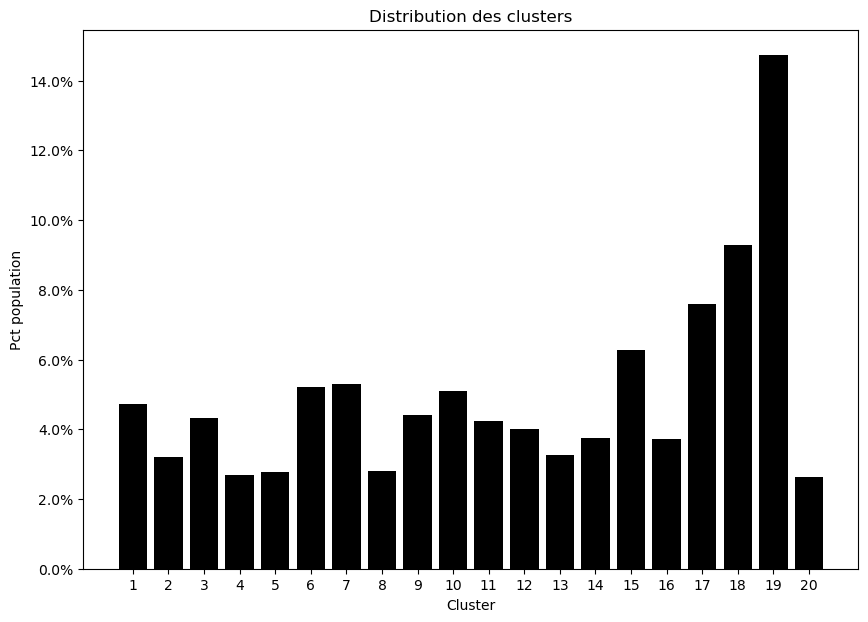

In [91]:
plt.figure(figsize=(10,7))
labels, counts = np.unique(kmedoids.labels_, return_counts=True)
counts = counts / len(kmedoids.labels_)
plt.bar(labels+1, counts, align='center', color = 'black')
plt.gca().set_xticks(labels+1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Distribution des clusters')
plt.xlabel("Cluster")
plt.ylabel('Pct population')
plt.show()

##### Ajout des clusters dans la base

In [72]:
base_patient = base_patient.drop(columns=["cluster"])

In [73]:
for i in range(1, n_clusters+1):
    base_patient["cluster"+str(i)] = [0]*len(base_patient)

In [74]:
for i, label in enumerate(kmedoids.labels_):
    base_patient.loc[i, "cluster"+str(label+1)] = 1

##### Ajout d'une colonne contenant les parcours de soins

In [84]:
base_patient['p_soins'] = ['']*len(base_patient)

In [86]:
for i, patient in enumerate(X_patient):
    p_soin = convert_to_sentence(patient)
    base_patient.loc[i, 'p_soins'] = p_soin

In [94]:
base_patient.head(3)

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,...,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18,cluster19,cluster20,p_soins
0,P0,2011-11-22,1949,11,1,NaN,False,2596,9,False,...,0,0,0,0,0,0,0,0,0,"05K051,05M042,05M16T,05M09T,05M092,05C191,05M2..."
1,P6,2013-12-05,1929,14,2,2015-03,True,456,8,False,...,0,0,0,0,0,1,0,0,0,"02C05J,02C05J,05M093,04M132,05C222,23M103,04M0..."
2,P8,2015-07-02,1967,54,2,2015-08,True,41,3,True,...,0,0,0,0,0,0,1,0,0,"11M041,06C194"


In [88]:
base_patient.to_csv("../data/profil_patient_cluster.csv", index=False)

# Visualisation dex clusters

In [100]:
clusters = kmedoids.labels_

##### Moyenne age

In [106]:
avg_ynais_cluster = [0]*n_clusters
for i in range(1, n_clusters+1):
    base_patient_cluster_i = base_patient.loc[base_patient["cluster" + str(i)] == 1]
    avg_ynais_cluster[i-1] = base_patient_cluster_i.y_nais.mean()

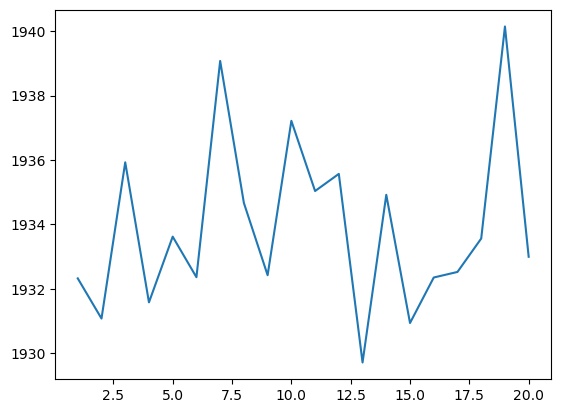

In [110]:
plt.plot(range(1, n_clusters+1), avg_ynais_cluster)